# Statistical Inference on the Composition of Red Wine
Group: 44

Members: Anthony Leong, Arav Dewan, Nikita Prabhu, Xiaomeng Zhou

### Introduction

As a commodity to be consumed, the quality of wine is of great importance, though it can differ greatly from wine to wine. A possible factor that influences the quality of a wine is its composition, so this study will aim to use statistical inference to determine if there is a significant difference between the compositions of different quality wines.

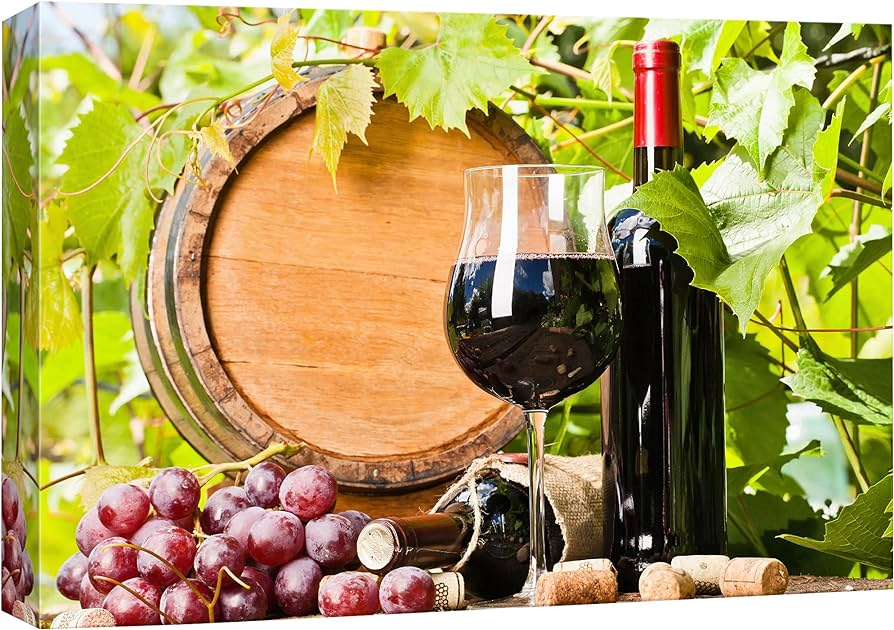

The dataset used is the [Wine Quality](https://archive.ics.uci.edu/dataset/186/wine+quality) dataset from the UCI machine learning repository, and it consists of red and white variants of *vinho verde* wine. For this study, we will only be using red wine and we will classify each wine as either "low" or "high" quality.

Wine quality is linked to what is referred to as the sugar-acid balance, so understanding how the acidity of a wine affects its quality is of significant importance. Therefore, the variables of interest are `fixed_acidity` and `volatile_acidity`, and our research question is:

**Do fixed acidity and volatile acidity differ between different qualities of red wine?**

### Preliminary Results

In [61]:
#loading necessary packages
library(cowplot)
library(digest)
library(infer)
library(repr)
library(tidyverse)
library(datateachr)
library(gridExtra)
install.packages("corrplot")
library(corrplot)


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [62]:
#reading dataset
options(repr.matrix.max.rows = 8)
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
raw_wine_data <- read_delim(url, skip = 1, delim = ";",
                            col_names = c("fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar",
                                          "chlorides", "free_sulfur_dioxide", "total_sulfur_dioxide",
                                          "density", "pH", "sulphates", "alcohol", "quality"))
head(raw_wine_data)

Rows: 1599 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
dbl (12): fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5


Table 1: Raw dataset of red wines

There are many possible ways to classify each wine as either "low" or "high" quality, but for this study, we will use the mean of quality as the cutoff between “low” and “high” quality.

In [63]:
#converting quality to "HIGH" or "LOW"
mean_quality <- raw_wine_data |>
    summarize(mean_quality = mean(quality)) |>
    pull()

low_quality <- raw_wine_data |>
    filter(quality <= mean_quality) |>
    mutate(quality = "LOW")

high_quality <- raw_wine_data |>
    filter(quality > mean_quality) |>
    mutate(quality = "HIGH")

wine_data <- bind_rows(low_quality, high_quality)
head(wine_data)

fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,LOW
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,LOW
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,LOW
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,LOW
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,LOW
7.9,0.60,0.06,1.6,0.069,15,59,0.9964,3.30,0.46,9.4,LOW


Table 2: Dataset of red wines, classified as either "HIGH" or "LOW" quality

Now that each wine has been classified, we can compute summary statistics to estimate various parameters across each category of wine quality, and also visualize the distributions of our two variables of interest across each category of wine quality.

In [64]:
#calculate summary statistics

low_quality_stats <- low_quality |>
    summarize(Quality = "LOW",
              n = n(),
              "Fixed_Acidity_Mean" = mean(fixed_acidity),
              "Fixed_Acidity_SD" = sd(fixed_acidity),
              "Volatile_Acidity_Mean" = mean(volatile_acidity),
              "Volatile_Acidity_SD" = sd(volatile_acidity))

high_quality_stats <- high_quality |>
    summarize(Quality = "HIGH",
              n = n(),
              "Fixed_Acidity_Mean" = mean(fixed_acidity),
              "Fixed_Acidity_SD" = sd(fixed_acidity),
              "Volatile_Acidity_Mean" = mean(volatile_acidity),
              "Volatile_Acidity_SD" = sd(volatile_acidity))

summary_stats <- bind_rows(low_quality_stats, high_quality_stats)
summary_stats

Quality,n,Fixed_Acidity_Mean,Fixed_Acidity_SD,Volatile_Acidity_Mean,Volatile_Acidity_SD
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
LOW,744,8.142204,1.572396,0.5895027,0.1779562
HIGH,855,8.474035,1.862795,0.4741462,0.1619993


Table 3: Table of summary statistics

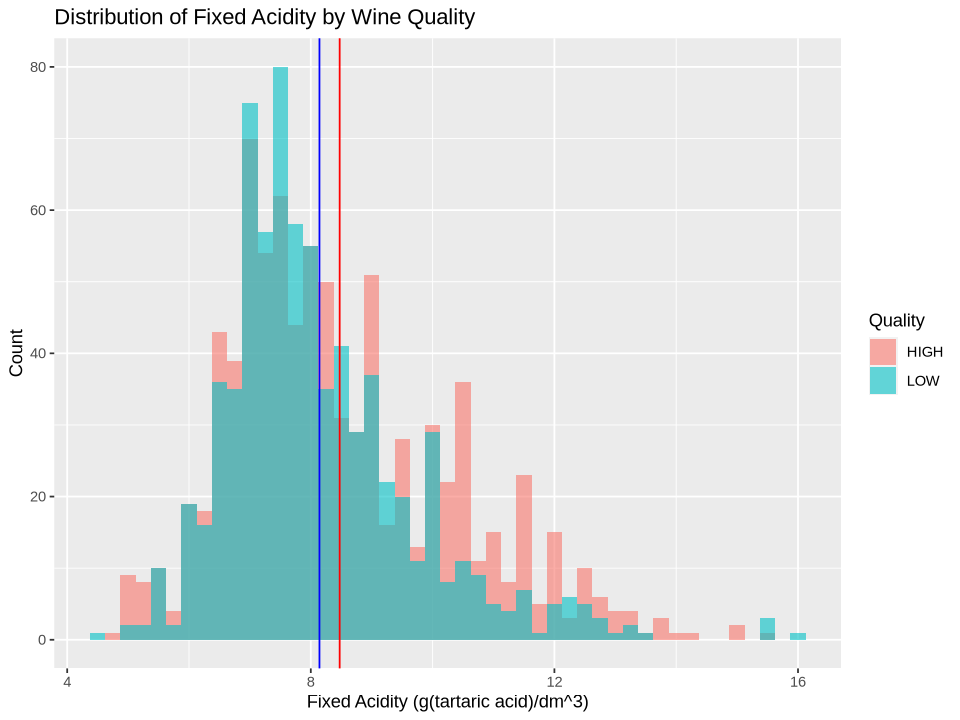

In [65]:
#visualizing the distribution of fixed acidity by wine quality
options(repr.plot.width = 8, repr.plot.height = 6)

fixed_plot <- wine_data |>
    ggplot(aes(x = fixed_acidity, fill = quality)) +
    geom_histogram(alpha = 0.6, position = "identity", binwidth = 0.25) +
    geom_vline(xintercept = 8.474035, color = "red") +
    geom_vline(xintercept = 8.142204, color = "blue") +
    labs(x = "Fixed Acidity (g(tartaric acid)/dm^3)",
         y = "Count",
         title = "Distribution of Fixed Acidity by Wine Quality",
         fill = "Quality")
fixed_plot

Figure 1: Histogram comparing the distribution of `fixed_acidity` between different wine qualities. The blue line is the mean of `fixed_acidity` for "low" quality wines, and the red line is the mean of `fixed_acidity` for "high" quality wines.

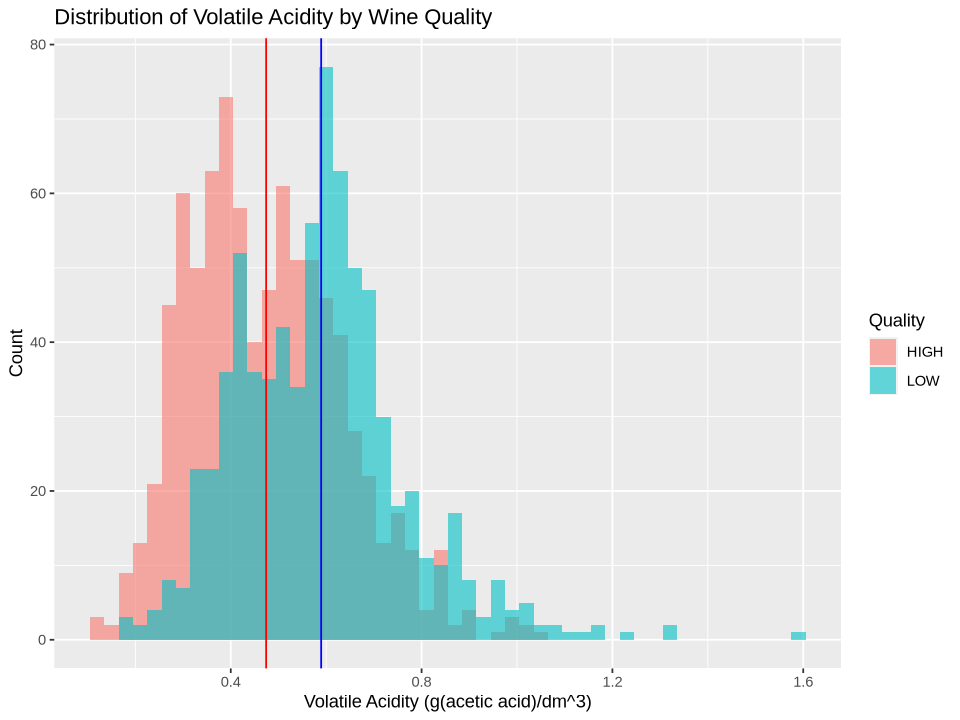

In [66]:
#visualizing the distribution of volatile acidity by wine quality
options(repr.plot.width = 8, repr.plot.height = 6)

fixed_plot <- wine_data |>
    ggplot(aes(x = volatile_acidity, fill = quality)) +
    geom_histogram(alpha = 0.6, position = "identity", binwidth = 0.03) +
    geom_vline(xintercept = 0.4741462, color = "red") +
    geom_vline(xintercept = 0.5895027, color = "blue") +
    labs(x = "Volatile Acidity (g(acetic acid)/dm^3)",
         y = "Count",
         title = "Distribution of Volatile Acidity by Wine Quality",
         fill = "Quality")
fixed_plot

Figure 2: Histogram comparing the distribution of `volatile_acidity` between different wine qualities. The blue line is the mean of `volatile_acidity` for "low" quality wines, and the red line is the mean of `volatile_acidity` for "high" quality wines.

<font size="5">Constructing Confidence Intervals through bootstrapping</font>

<font size="3">Constructing Confidence Intervals through bootstrapping for `fixed_acidity`</font>

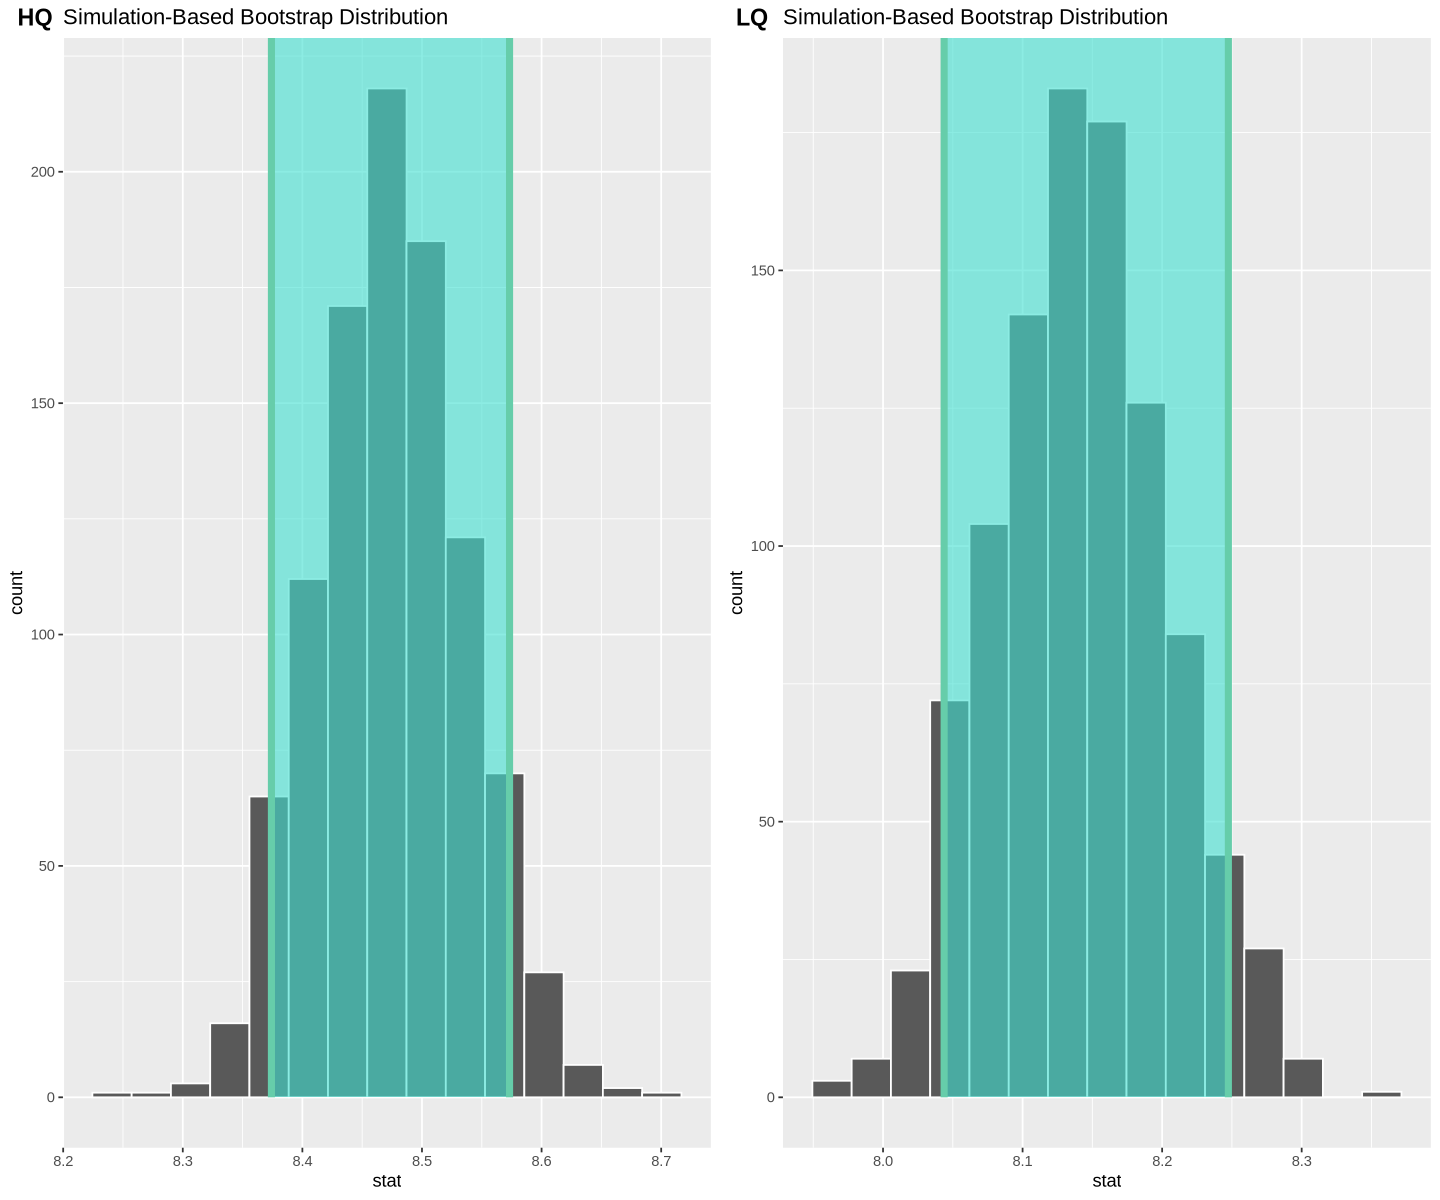

In [68]:
set.seed(123)
#CONSTRUCTING CONFIDENCE INTERVALS OF FIXED ACIDITY FOR HIGH QUALITY WINE 
# Wine quality data selecting quality and fixed acidity
wine_quality_fa <- wine_data |>
select(quality,fixed_acidity)

# Wine quality data selecting high quality wine and fixed acidity
wine_quality_fa_h <- wine_quality_fa |>
filter(quality == "HIGH")

#generate bootstrap resampling with replacement
bootstrapped_fa_1 <- wine_quality_fa_h %>% 
    specify(response = fixed_acidity) %>% 
    generate(type = "bootstrap", reps = 1000) %>% 
    calculate(stat = "mean")

#calculate 90% confidence interval 
c1_fa_1 <- bootstrapped_fa_1 %>% 
    get_confidence_interval(level = 0.90, type = "percentile")

#visualize the confidence interval 
fa_plot1 <- visualize(bootstrapped_fa_1) + 
  shade_confidence_interval(endpoints = c1_fa_1)

#CONSTRUCTING CONFIDENCE INTERVALS OF FIXED ACIDITY FOR LOW QUALITY WINE 
# Wine quality data selcting low quality wine and fixed acidity
wine_quality_fa_l <- wine_quality_fa |>
filter(quality == "LOW")

#generate bootstrap resampling with replacement
bootstrapped_fa_2 <- wine_quality_fa_l %>% 
    specify(response = fixed_acidity) %>% 
    generate(type = "bootstrap", reps = 1000) %>% 
    calculate(stat = "mean")

#calculate 90% confidence interval 
c1_fa_2 <- bootstrapped_fa_2 %>% 
    get_confidence_interval(level = 0.90, type = "percentile")

#visualize the confidence interval 
fa_plot2<- visualize(bootstrapped_fa_2) + 
  shade_confidence_interval(endpoints = c1_fa_2)

options(repr.plot.width=12,repr.plot.height=10)
plot_grid(fa_plot1,fa_plot2,labels = c('HQ', 'LQ'))

<font size="5">Conducting Hypthesis testing through two sample t-test</font>

Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.”


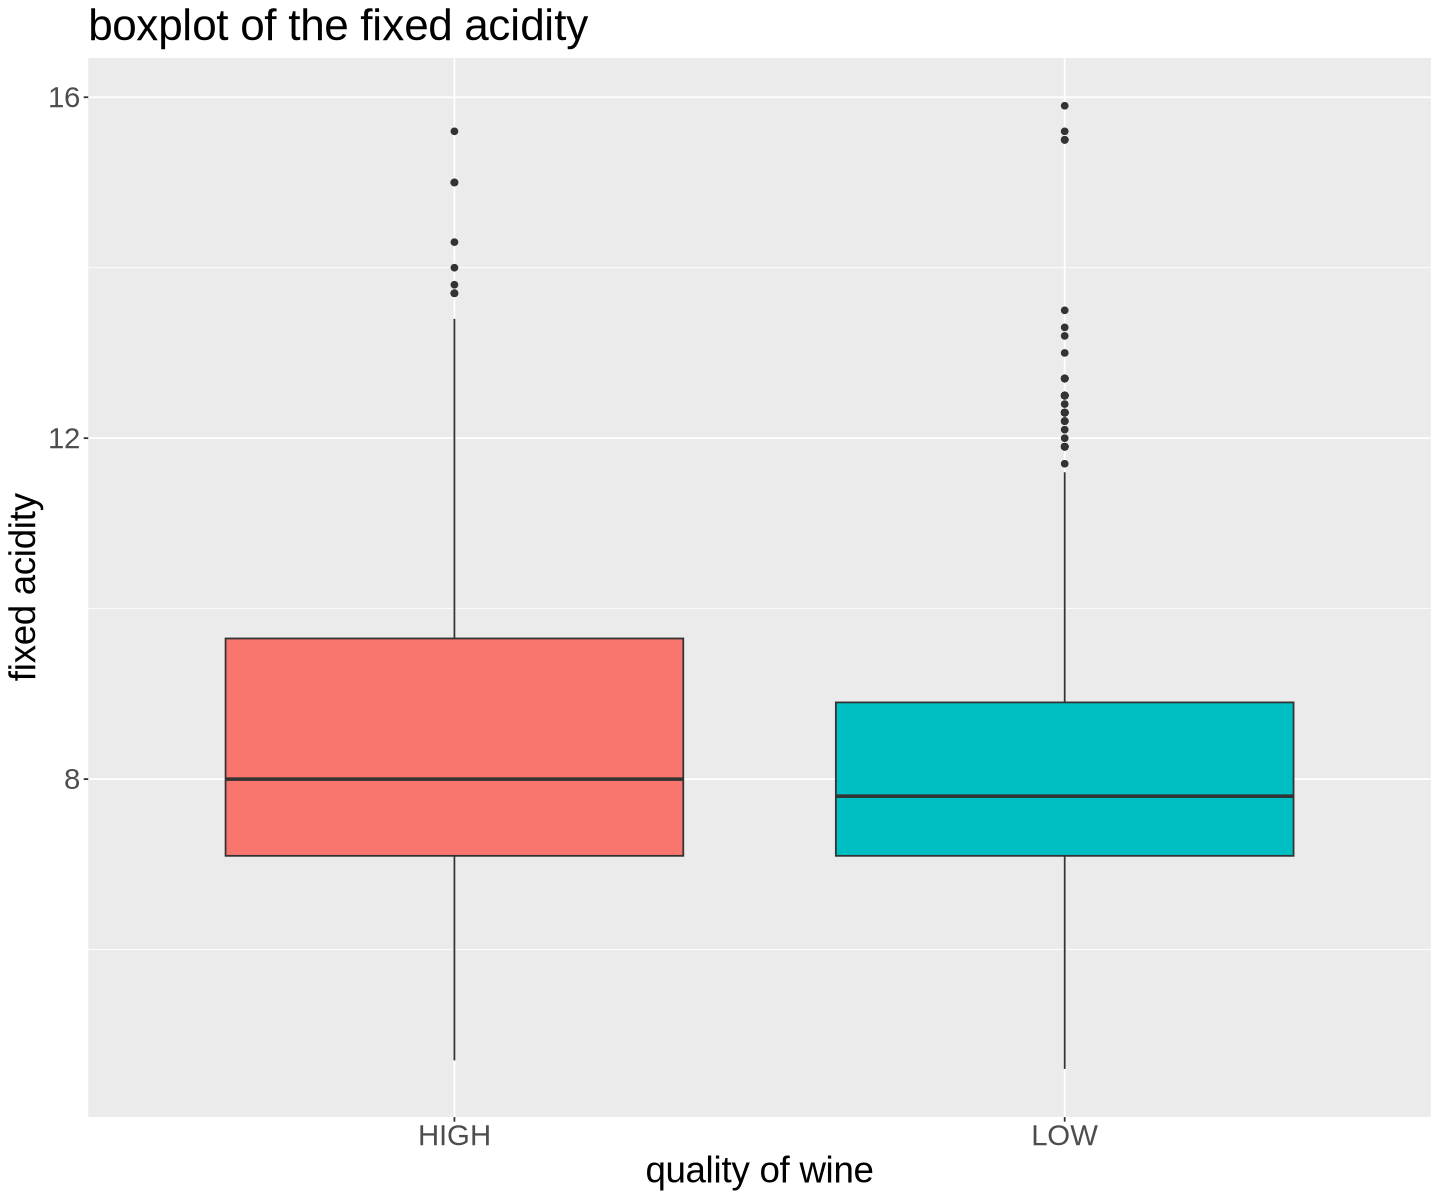

In [69]:
# Wine quality data selecting quality and fixed acidity
wine_quality_fa <- wine_data |>
select(quality,fixed_acidity)

#boxplot of the fixed acidity of low quality and high quality wine
wine_quality_fa_boxplots <-
    wine_quality_fa %>% 
    ggplot() +
    geom_boxplot(aes(quality, fixed_acidity, fill = quality)) +
    theme(text = element_text(size = 22)) +
    ggtitle("boxplot of the fixed acidity") + 
    xlab("quality of wine") + 
    ylab("fixed acidity") + 
    guides(fill = FALSE)
wine_quality_fa_boxplots

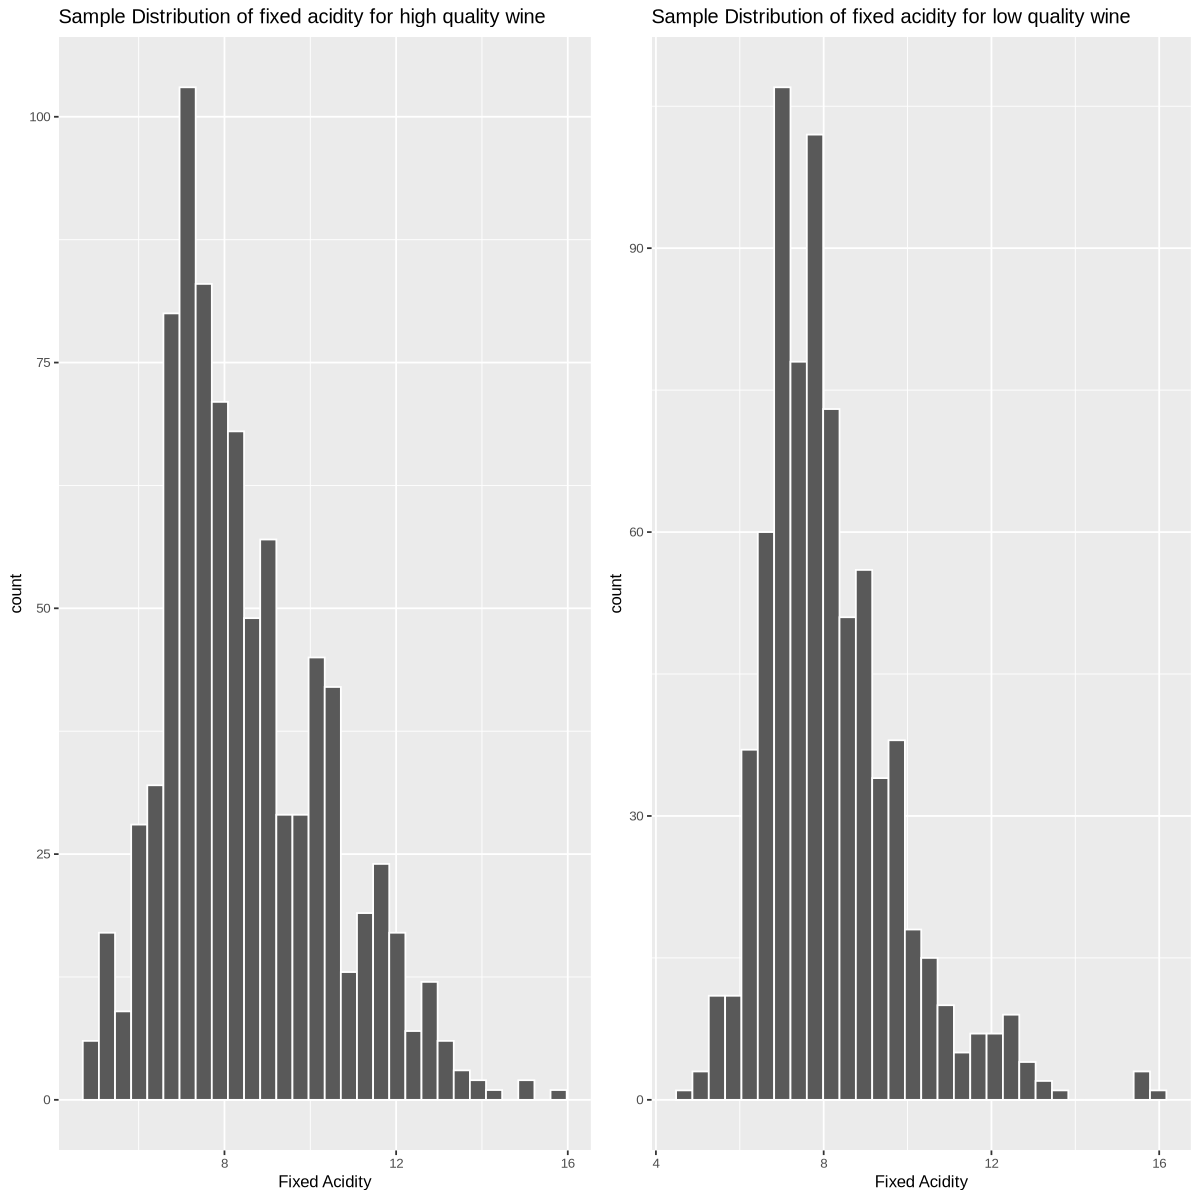

In [70]:
#Checking whether the distribution for both the samples is roughly normal to use the null model
wine_quality_fa_h <- wine_quality_fa |>
filter(quality == "HIGH")

wine_quality_fa_h_plot <- wine_quality_fa_h |>
ggplot(aes(x = fixed_acidity))+
geom_histogram(bins=30,color = 'white')+
labs(title = "Sample Distribution of fixed acidity for high quality wine",
         x = "Fixed Acidity")+
    theme(text = element_text(size = 10))

wine_quality_fa_l <- wine_quality_fa |>
filter(quality == "LOW")

wine_quality_fa_l_plot <- wine_quality_fa_l |>
ggplot(aes(x = fixed_acidity))+
geom_histogram(bins=30,color = 'white')+
labs(title = "Sample Distribution of fixed acidity for low quality wine",
         x = "Fixed Acidity")+
    theme(text = element_text(size = 10))

options(repr.plot.width=10,repr.plot.height=10)
plot_grid(wine_quality_fa_h_plot,wine_quality_fa_l_plot)

In [71]:
#Two sample t_test
fa_t_test <- 
    broom::tidy(
        t.test(x = filter(wine_quality_fa, quality == "HIGH")$fixed_acidity,
               y = filter(wine_quality_fa, quality == "LOW")$fixed_acidity,
               alternative = "two.sided",conf.level = 0.90))

fa_t_test
print(paste("The test statistic:", fa_t_test$statistic))
print(paste("The p value", fa_t_test$p.value))

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.3318308,8.474035,8.142204,3.862248,0.00011684,1595.546,0.1904287,0.4732329,Welch Two Sample t-test,two.sided


[1] "The test statistic: 3.86224833222984"
[1] "The p value 0.000116839973842088"


[1] "The observed mean difference in fixed acidity : 0.33183078664403"


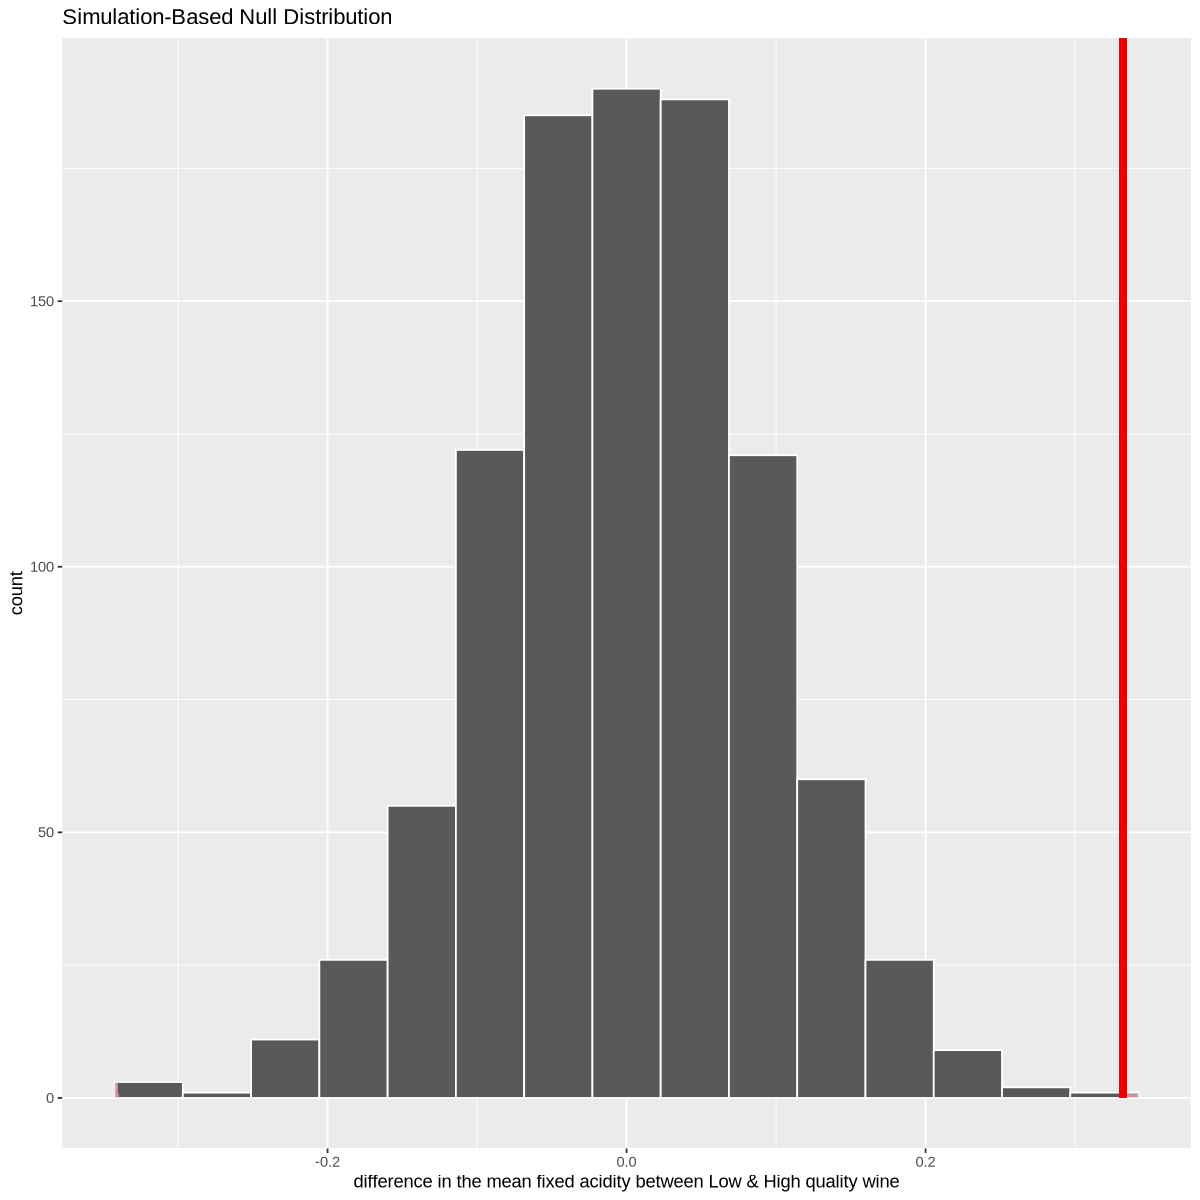

In [72]:
#Calculating the observed mean difference in fixed acidity
obs_mean_fa_diff <- 
     wine_quality_fa %>% 
    filter(quality %in% c("LOW", "HIGH")) %>%
     group_by(quality) %>% 
     summarise(mean = mean(fixed_acidity)) %>%
     pivot_wider(names_from = quality, values_from = mean) %>%
     transmute(diff = HIGH-LOW) %>%
     pull(diff)
print(paste("The observed mean difference in fixed acidity :", obs_mean_fa_diff))

#Simulating from the null distribution
null_model_fa <- 
   wine_quality_fa %>% 
    specify(formula = fixed_acidity~quality) %>% 
    hypothesize(null = "independence") %>% 
    generate(reps = 1000, type = "permute") %>% 
    calculate(stat="diff in means", order = c("HIGH", "LOW"))

null_model_fa_plot <- 
    null_model_fa %>%
    visualize() + 
    xlab("difference in the mean fixed acidity between Low & High quality wine")+
    shade_p_value(obs_stat = obs_mean_fa_diff, direction = "two.sided")

null_model_fa_plot

In [73]:
# Wine quality data selecting quality and volatile acidity
wine_quality_va <- wine_data |>
select(quality,volatile_acidity)
head(wine_quality_va)


quality,volatile_acidity
<chr>,<dbl>
LOW,0.70
LOW,0.88
LOW,0.76
LOW,0.70
LOW,0.66
LOW,0.60


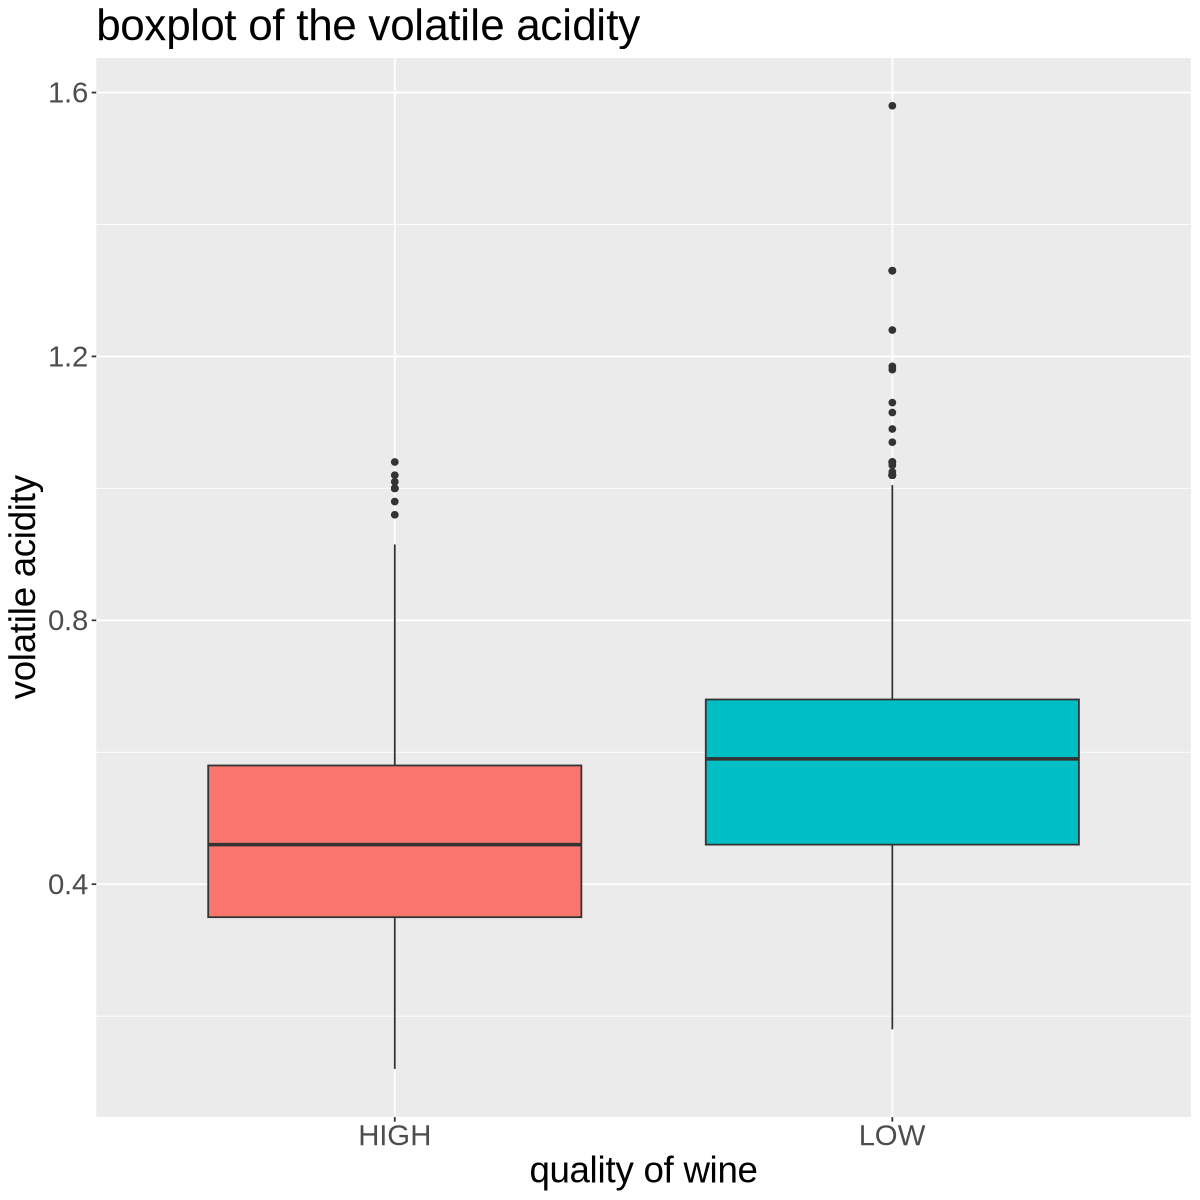

In [74]:
#boxplot of the volatile acidity of low quality and high quality wine
wine_quality_va_boxplots <-
    wine_quality_va %>% 
    ggplot() +
    geom_boxplot(aes(quality, volatile_acidity, fill = quality)) +
    theme(text = element_text(size = 22)) +
    ggtitle("boxplot of the volatile acidity") + 
    xlab("quality of wine") + 
    ylab("volatile acidity") + 
    guides(fill = FALSE)
wine_quality_va_boxplots

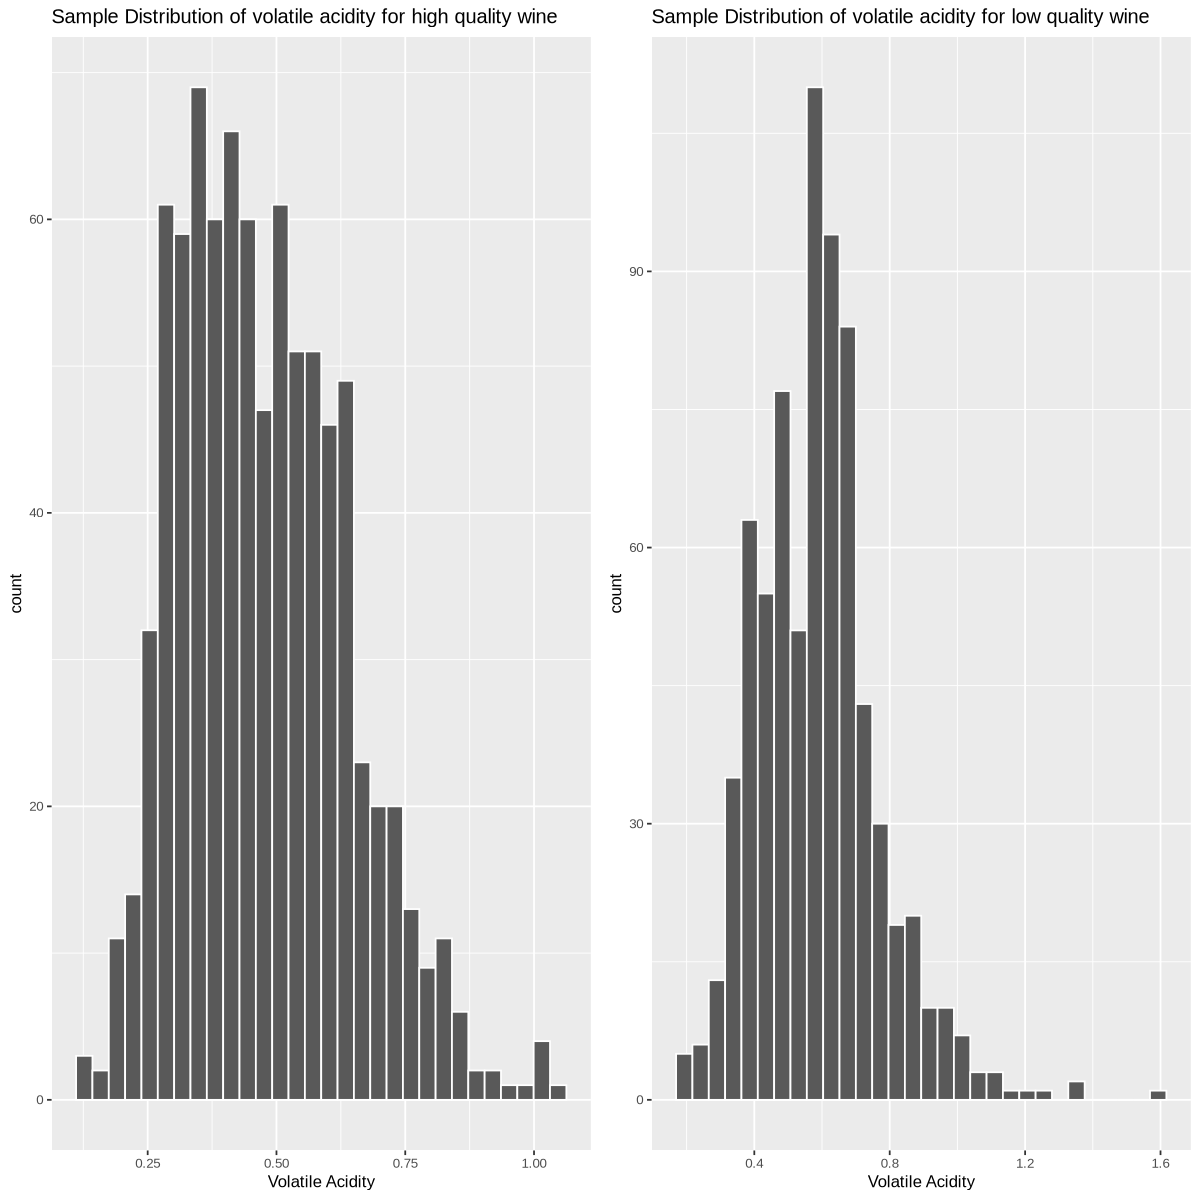

In [75]:
#Checking whether the distribution for both the samples is normal to use the null model
wine_quality_va_h <- wine_quality_va |>
filter(quality == "HIGH")

wine_quality_va_h_plot <- wine_quality_va_h |>
ggplot(aes(x = volatile_acidity))+
geom_histogram(bins = 30,color = 'white')+
labs(title = "Sample Distribution of volatile acidity for high quality wine",
         x = "Volatile Acidity")+
    theme(text = element_text(size = 10))

wine_quality_va_l <- wine_quality_va |>
filter(quality == "LOW")

wine_quality_va_l_plot <- wine_quality_va_l |>
ggplot(aes(x = volatile_acidity))+
geom_histogram(bins = 30,color = 'white')+
labs(title = "Sample Distribution of volatile acidity for low quality wine",
         x = "Volatile Acidity")+
    theme(text = element_text(size = 10))

options(repr.plot.width=10,repr.plot.height=10)
plot_grid(wine_quality_va_h_plot,wine_quality_va_l_plot)

In [76]:
# Two sample t-test
va_t_test <- 
    broom::tidy(
        t.test(x = filter(wine_quality_va, quality == "HIGH")$volatile_acidity,
               y = filter(wine_quality_va, quality == "LOW")$volatile_acidity,
               alternative = "two.sided",conf.level = 0.90))


va_t_test
print(paste("The test statistic:", va_t_test$statistic))
print(paste("The p value", va_t_test$p.value))

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
-0.1153565,0.4741462,0.5895027,-13.47752,3.480735e-39,1515.366,-0.1294437,-0.1012693,Welch Two Sample t-test,two.sided


[1] "The test statistic: -13.4775214279703"
[1] "The p value 3.48073532887764e-39"


[1] "The observed mean difference in volatile acidity : -0.115356489341634"


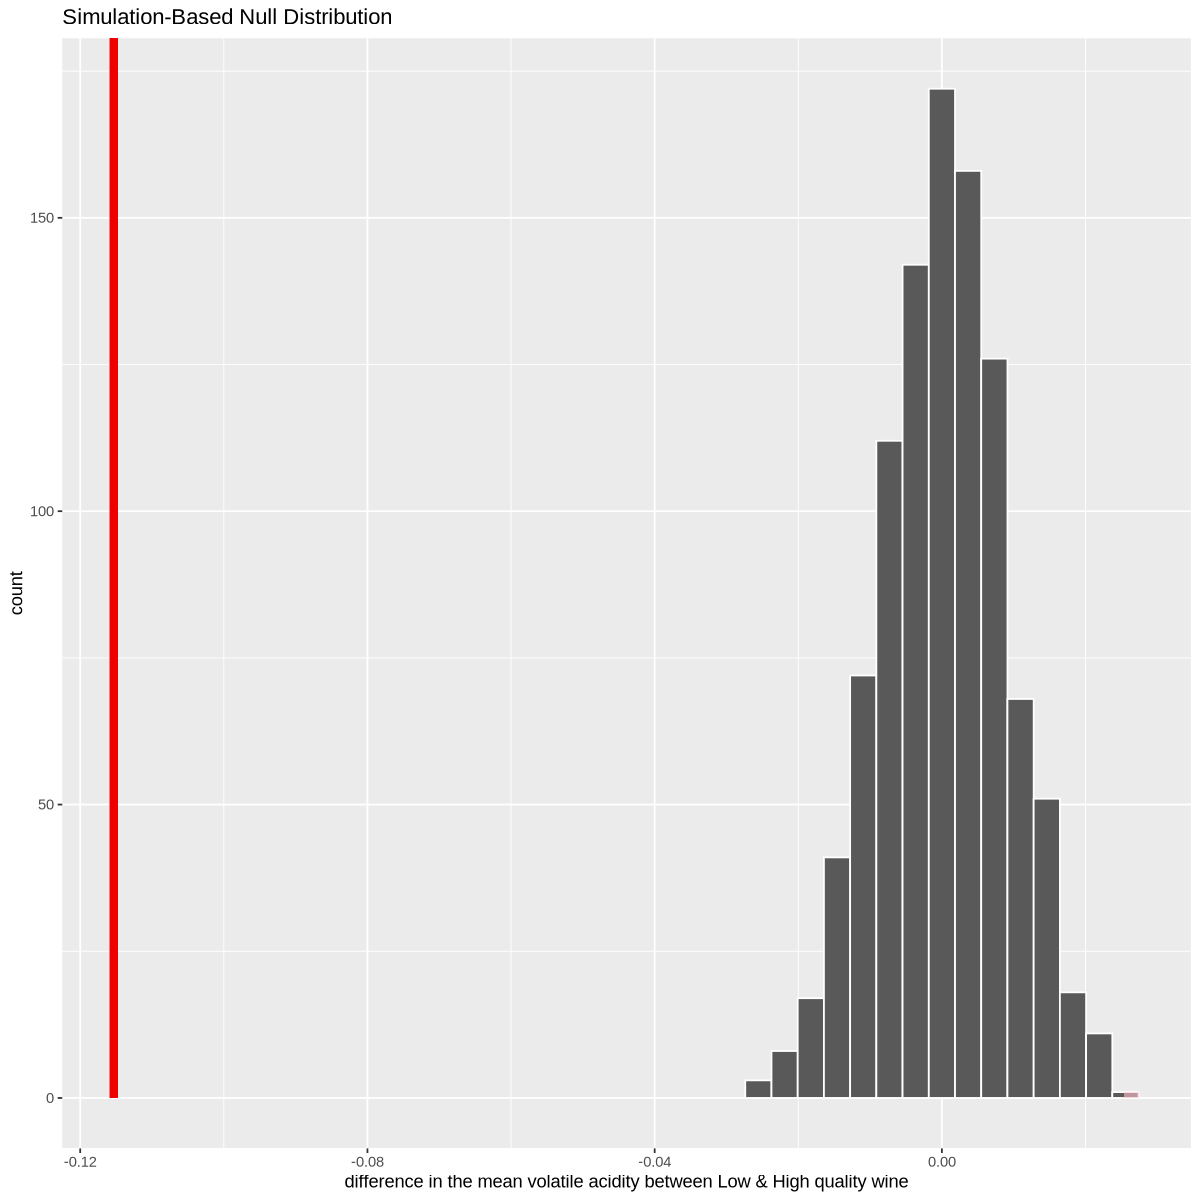

In [77]:
#Calculating the observed mean difference in fixed acidity
obs_mean_va_diff <- 
     wine_quality_va %>% 
    filter(quality %in% c("LOW", "HIGH")) %>%
     group_by(quality) %>% 
     summarise(mean = mean(volatile_acidity)) %>%
     pivot_wider(names_from = quality, values_from = mean) %>%
     transmute(diff = HIGH-LOW) %>%
     pull(diff)
print(paste("The observed mean difference in volatile acidity :", obs_mean_va_diff))

#Simulating from the null distribution
null_model_va <- 
   wine_quality_va %>% 
    specify(formula = volatile_acidity~quality) %>% 
    hypothesize(null = "independence") %>% 
    generate(reps = 1000, type = "permute") %>% 
    calculate(stat="diff in means", order = c("HIGH", "LOW"))

null_model_va_plot <- 
    null_model_va %>%
    visualize() + 
    xlab("difference in the mean volatile acidity between Low & High quality wine")+
    shade_p_value(obs_stat = obs_mean_va_diff, direction = "two.sided")

null_model_va_plot


### Methods: Plan

In this report, we will use rigorous statistical inference methods (hypothesis testing and confidence intervals) and our data source is reliable (UC Irvine Machine Learning Repository), so our report should be trustworthy.

Although we have computed point estimates for the means of `fixed_acidity` and `volatile_acidity`, these findings would not be enough to present to a stakeholder, as we have not determined the uncertainty associated with each point estimate. We will remedy this by using hypothesis tests and constructing confidence intervals through bootstrap sampling.

Let $\mu_{fh}$, $\mu_{fl}$, $\mu_{vh}$, and $\mu_{vl}$ be defined as follows:

- $\mu_{fh}$ represents the population mean of `fixed_acidity` for "high" quality wines
- $\mu_{fl}$ represent the population mean of `fixed_acidity` for "low" quality wines
- $\mu_{vh}$ represent the population mean of `volatile_acidity` for "high" quality wines
- $\mu_{vl}$ represent the population mean of `volatile_acidity` for "low" quality wines

Hypothesis tests 1: \
$H_0$: $\mu_{fh} - \mu_{fl} = 0$\
$H_1$: $\mu_{fh} - \mu_{fl} \neq 0$

Hypothesis tests 2: \
$H_0$: $\mu_{vh} - \mu_{vl} = 0$\
$H_1$: $\mu_{vh} - \mu_{vl} \neq 0$

For both hypothesis tests, we will use $\alpha = 0.1$ as our significance level.

We will use bootstrap resampling with replacement to construct $90 \%$ confidence intervals for:
- The difference in the mean of `fixed_acidity` between different wine qualities
- The difference in the mean of `volatile_acidity` between "high" and "low" quality wine

From looking at Figures 1 and 2, we expect that the mean of `fixed_acidity` would not be significantly different between "low" and "high" quality red wine. On the other hand, we expect that the mean of `volatile_acidity` would be significantly different between "low" quality and "high" quality red wine.

The results of this analysis will provide important information that can be used by wine producers to adjust their winemaking processes to improve their wine quality, and by consumers to be able to better judge the quality of wine before they purchase it.

If this analysis is successful, we could extend this analysis to other types of wine and/or other variables that significantly affect wine quality.

### References

- Ferrer, J., Huang, Z., Kiang, M., Moreno, I., Shaw, M., Wang, W., Asuncion, A., Bi, J., Bishop, C., Boser, B., Cherkassy, V., Cortez, P., Dietterich, T., Ebeler, S., &amp; Fao. (2009, June 9). Modeling wine preferences by data mining from physicochemical properties. Decision Support Systems. https://www.sciencedirect.com/science/article/pii/S0167923609001377  
- UCI Machine Learning Repository: Wine Quality Data Set. (n.d.). UCI. https://archive.ics.uci.edu/ml/datasets/wine+quality
- White, N. A. (2019, March 18). Fixed acidity. Waterhouse Lab. https://waterhouse.ucdavis.edu/whats-in-wine/fixed-acidity
- White, N. A. (2019, March 18). Volatile acidity. Waterhouse Lab. https://waterhouse.ucdavis.edu/whats-in-wine/volatile-acidity